In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import statistics as sts
import numpy as np
import seaborn as sns
import pickle
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
%matplotlib inline

## Functions

### Graph Features

In [2]:
# it receives a path to a graph file, 
# it returns a numpy array with the graph features  
def get_graph_features(graph):
    max_degree = max(dict(nx.degree(graph)).values())
    min_degree = min(dict(nx.degree(graph)).values())
    avg_degree = sts.mean(dict(nx.degree(graph)).values())
    qtd_max_degree = list(dict(nx.degree(graph)).values()).count(max_degree)
    qtd_min_degree = list(dict(nx.degree(graph)).values()).count(min_degree)
    density = nx.density(graph)
    
    return np.array([max_degree, qtd_max_degree, min_degree, qtd_min_degree, avg_degree, density]).reshape(1, -1)

### Confusion Matrix

In [3]:
def plot_confusion_matrix(matrix):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    matrix.flatten()]
    
    group_percentages = ["{0:.2%}".format(value) for value in
                         matrix.flatten()/np.sum(matrix)]
    
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names, group_counts, group_percentages)]
    
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues')
    plt.show()

## Random Graph File

In [4]:
graph = nx.read_gexf('./graphs/ba.gexf')
graph_features = get_graph_features(graph)

## Full DataSet

In [5]:
graph_df = pd.read_csv('https://gitlab.com/viniciusmioto/graph_dataset/-/raw/main/graphs_db.csv')
graph_df

,max_degree,qtd_max_degree,min_degree,qtd_min_degree,avg_degree,density,is_power_law
0,246,1,3,3391,5.997885,0.000705,1
1,176,1,3,1503,5.995263,0.001578,1
2,379,1,5,2385,9.993983,0.001203,1
3,142,1,2,1982,3.997970,0.001015,1
4,398,1,5,2710,9.994828,0.001034,1
...,...,...,...,...,...,...,...
3137,504,1,1,1281,21.106968,0.001124,1
3138,281,1,1,2373,8.083431,0.000349,1
3139,65,1,1,2108,5.264352,0.000533,1
3140,7636,1,1,225942,2.756793,0.000010,1


In [6]:
# separating features and labels
X = np.array(graph_df.drop(['is_power_law'], 1))
y = np.array(graph_df['is_power_law'])

/tmp/ipykernel_36041/2903080007.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = np.array(graph_df.drop(['is_power_law'], 1))


In [7]:
# train/test slipt
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## k-Nearest Neighbors

In [8]:
# find best number (N) of neighbors
param_grid = {'n_neighbors':[3,5,11]}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid)
grid_search.fit(X_train, y_train)
neighbors = grid_search.best_estimator_.n_neighbors
print('Best number of neighbors: ' + str(neighbors))

# train model with N neighbors
knn_model = KNeighborsClassifier(n_neighbors=neighbors)
knn_model.fit(X_train, y_train)

Best number of neighbors: 3


KNeighborsClassifier(n_neighbors=3)

In [9]:
print("Accuracy: ", knn_model.score(X_test, y_test))

Accuracy:  0.9872746553552492


In [10]:
print("Training set score: {:.2f}".format(knn_model.score(X_train, y_train)),
      "\nTest set score: {:.2f}".format(knn_model.score(X_test, y_test)))

Training set score: 0.99 
Test set score: 0.99


In [11]:
y_predict_knn = knn_model.predict(X_test)
knn_conf_matrix = confusion_matrix(y_test, y_predict_knn)

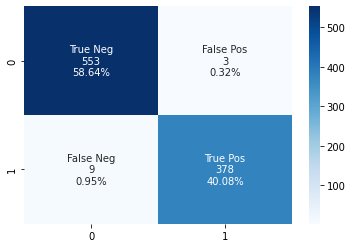

In [12]:
plot_confusion_matrix(knn_conf_matrix)

In [13]:
knn_model.predict(graph_features)

array([1])

In [14]:
# with open('./models/knn_model.pkl', 'wb') as file:
#     pickle.dump(knn_model, file)

## Support Vector Machines

In [15]:
# find best values of C and Gamma
c_values = [0.1, 1, 10, 100, 1000]
gamma_values = [0.001, 0.01, 0.1, 1]

param_grid = {'C': c_values, 'gamma': gamma_values}
grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# set C and Gamma values
c = grid_search.best_estimator_.C
gamma = grid_search.best_estimator_.gamma
print('Best C: ', c)
print('Best Gamma ', gamma)

svm_model = SVC(C=c, gamma=gamma, kernel='rbf',probability=True)
svm_model.fit(X_train, y_train)

Best C:  10
Best Gamma  0.001


SVC(C=10, gamma=0.001, probability=True)

In [16]:
print("Accuracy: ", knn_model.score(X_test, y_test))

Accuracy:  0.9872746553552492


In [17]:
print("Training set score: {:.2f}".format(svm_model.score(X_train, y_train)),
      "\nTest set score: {:.2f}".format(svm_model.score(X_test, y_test)))

Training set score: 1.00 
Test set score: 0.95


In [18]:
y_predict_svm = svm_model.predict(X_test)
svm_conf_matrix = confusion_matrix(y_test, y_predict_svm)

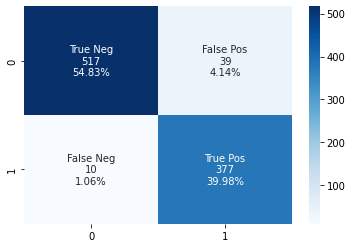

In [19]:
plot_confusion_matrix(svm_conf_matrix)

In [20]:
svm_model.predict(graph_features)

array([1])

In [21]:
# with open('./models/svm_model.pkl', 'wb') as file:
#     pickle.dump(svm_model, file)

## Random Forest

In [22]:
# find best n_estimators and max_depth
param_grid = {'n_estimators': [50, 100, 200],
              'max_depth': [3, 5, 9, 10]}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid)
grid_search.fit(X_train, y_train)

# setting n_estimators and max_depth values
n_estimators = grid_search.best_estimator_.n_estimators
max_depth = grid_search.best_estimator_.max_depth

print('Best n_estimators:', n_estimators)
print('Best max_depth:', max_depth)

# training the model
forest_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
forest_model.fit(X_train, y_train)

Best n_estimators: 50
Best max_depth: 5


RandomForestClassifier(max_depth=5, n_estimators=50)

In [23]:
print("Accuracy: ", forest_model.score(X_test, y_test))

Accuracy:  0.9989395546129375


In [24]:
print("Training set score: {:.2f}".format(forest_model.score(X_train, y_train)),
      "\nTest set score: {:.2f}".format(forest_model.score(X_test, y_test)))

Training set score: 1.00 
Test set score: 1.00


In [25]:
y_predict_forest = forest_model.predict(X_test)
forest_conf_matrix = confusion_matrix(y_test, y_predict_forest)

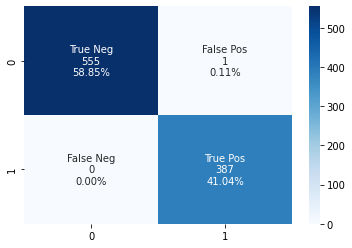

In [26]:
plot_confusion_matrix(forest_conf_matrix)

In [27]:
forest_model.predict(graph_features)

array([1])

In [28]:
# with open('./models/forest_model.pkl', 'wb') as file:
#     pickle.dump(forest_model, file)

## Gradient Boosting

In [29]:
# find best n_estimators, learning_rate and max_depth
grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid)
grid_search.fit(X_train, y_train)

# setting the three parameters
n_estimators = grid_search.best_estimator_.n_estimators
learning_rate = grid_search.best_estimator_.learning_rate
max_depth = grid_search.best_estimator_.max_depth

print('Best n_estimators:', n_estimators)
print('Best learning_rate:', learning_rate)
print('Best max_depth:', max_depth)

grad_boost_model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
grad_boost_model.fit(X_train, y_train)

Best n_estimators: 50
Best learning_rate: 0.1
Best max_depth: 3


GradientBoostingClassifier(n_estimators=50)

In [30]:
print("Accuracy: ", grad_boost_model.score(X_test, y_test))

Accuracy:  0.9978791092258749


In [31]:
print("Training set score: {:.2f}".format(grad_boost_model.score(X_train, y_train)),
      "\nTest set score: {:.2f}".format(grad_boost_model.score(X_test, y_test)))

Training set score: 1.00 
Test set score: 1.00


In [32]:
y_predict_grad_boost = grad_boost_model.predict(X_test)
grad_boost_conf_matrix = confusion_matrix(y_test, y_predict_grad_boost)

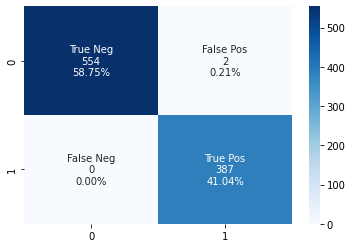

In [33]:
plot_confusion_matrix(grad_boost_conf_matrix)

In [34]:
# with open('./models/grad_boost_model.pkl', 'wb') as file:
#     pickle.dump(grad_boost_model, file)